In [1]:
import pandas as pd
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

2024-09-05 21:29:47.630096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
data = pd.read_csv('ambient_temperature_system_failure.csv')
#Exclude datetime column 
data_values = data.drop('timestamp',axis=1).values 
#Convert data to a float type 
data_values = data_values.astype('float32')
#create a new dataframe with the data converted 
data_converted = pd.DataFrame(data_values,columns=data.columns[1:])
# Add back datetime column
data_converted.insert(0, 'timestamp',data['timestamp'])


We load the “ambient_temperature_system_failure.csv” dataset from GitHub using pandas and store it in “data”. After dropping the “timestamp” column, the remaining values are converted to “float32” to reduce memory usage. The “timestamp” column is then reinserted into the new DataFrame “data_converted”.

In [10]:
# Remove a NaN value from dataset 
data_converted = data_converted.dropna()

# Nomaly Detection using Autoencoder
It is a type of neural network that learns to compress and then reconstruct the original data, allowing it to identify anomalies in the data.


In [17]:
# Exclude datetime column again
data_tensor = tf.convert_to_tensor(data_converted.drop(
    'timestamp', axis=1).values, dtype=tf.float32)

# Define the autoencoder model
input_dim = data_converted.shape[1] - 1
encoding_dim = 10

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile and fit the model
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data_tensor, data_tensor, epochs=50,
                batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions = autoencoder.predict(data_tensor)
mse = tf.reduce_mean(tf.square(data_tensor - reconstructions),
                     axis=1)
anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores')
anomaly_scores.index = data_converted.index


2024-09-05 21:44:00.322404: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-05 21:44:00.331492: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/50
228/228 [==============================] - 4s 14ms/step - loss: 439.7228
Epoch 2/50
228/228 [==============================] - 3s 14ms/step - loss: 0.1092
Epoch 3/50
228/228 [==============================] - 1s 4ms/step - loss: 6.5268e-04
Epoch 4/50
228/228 [==============================] - 1s 4ms/step - loss: 6.5233e-04
Epoch 5/50
228/228 [==============================] - 1s 3ms/step - loss: 6.5178e-04
Epoch 6/50
228/228 [==============================] - 1s 3ms/step - loss: 6.5218e-04
Epoch 7/50
228/228 [==============================] - 1s 3ms/step - loss: 6.5057e-04
Epoch 8/50
228/228 [==============================] - 1s 3ms/step - loss: 6.5062e-04
Epoch 9/50
228/228 [==============================] - 1s 3ms/step - loss: 6.4943e-04
Epoch 10/50
228/228 [==============================] - 1s 3ms/step - loss: 6.4911e-04
Epoch 11/50
228/228 [==============================] - 1s 4ms/step - loss: 6.4788e-04
Epoch 12/50
228/228 [==============================] - 1s 3ms/step 

In [19]:
threshold = anomaly_scores.quantile(0.99)
anomalous = anomaly_scores > threshold
binary_labels = anomalous.astype(int)
precision, recall,\
    f1_score, _ = precision_recall_fscore_support(
        binary_labels, anomalous, average='binary')


In [21]:
test = data_converted['value'].values
predictions = anomaly_scores.values

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)


Precision:  1.0
Recall:  1.0
F1 Score:  1.0


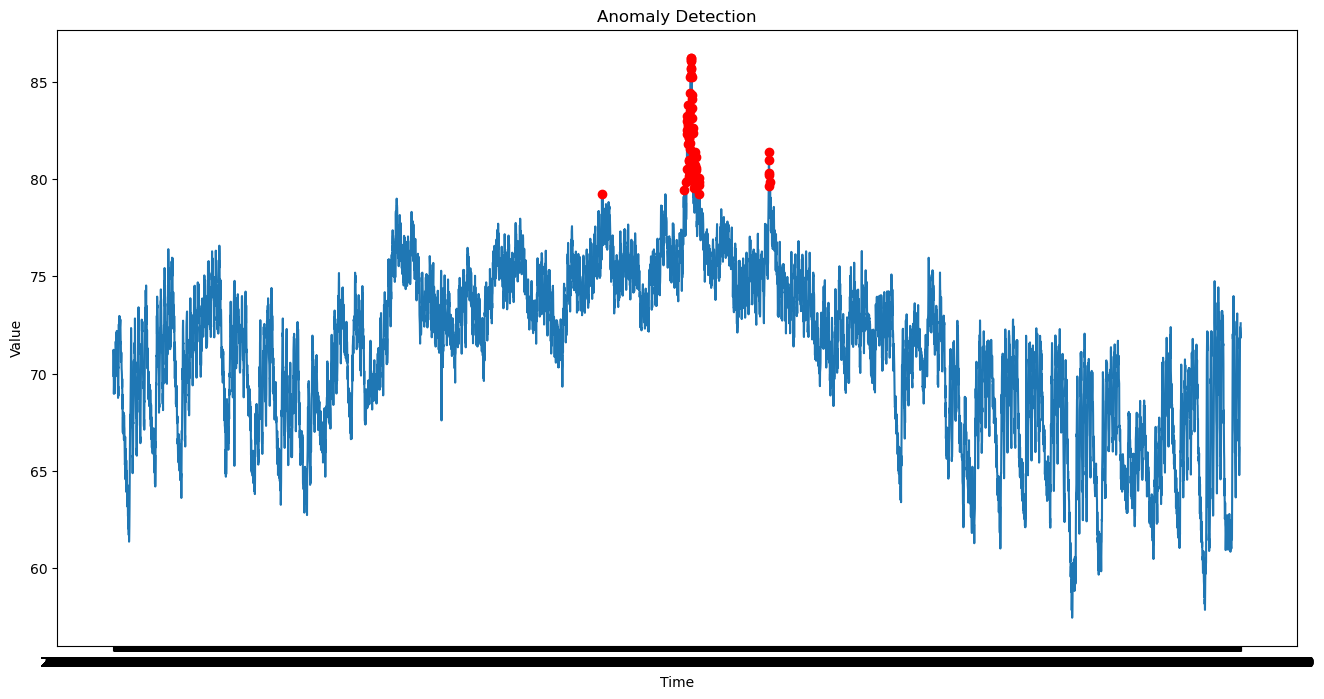

In [23]:
# Plot the data with anomalies marked in red
plt.figure(figsize=(16, 8))
plt.plot(data_converted['timestamp'],
         data_converted['value'])
plt.plot(data_converted['timestamp'][anomalous],
         data_converted['value'][anomalous], 'ro')
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()
